# A little theory on kNN

## Intuition

The algorithm $k$ Nearest Neighbours is one of the simpler machine learning algorithms. It is motivated by the ideas that similar examples $x_t$ should have similar targets $y_t$. So, to define an algorithm $k$-NN you only need to define what you mean by *similar* in the context of examples and define how neighbours influence the prediction of a target for test examples.

So, to predict the target class of a test examples $x$, all we need to do is find the $k$ nearest neighbours to $x$ using some metric (for example, euclidean distance also known as $L_2$ norm, or more generally minkowski distance $L_p$). Then we use those $k$ nearest neighbours to predict the target class of $x$. In a classification task, we would predict the target of $x$ to be the most common target of it's neighbours i.e. it's as though each neighbour of $x$ casts a vote for their own target class and the class with the most votes wins.

## Mathematic Formalism

Let

* $x$ be a test examples
* $m$ be the number of classes
* $D_n = \{(x_t,y_t)\}_{t=1}^n$ be the training data where $y_t \in Y=\{1,\dots,m\}$ is the corresponding target class of example $x_t$
* $d(\dot{},\dot{})$ be our distance metric
* $V(x,T,d(\dot{},\dot{}),k)$ l'ensemble des $k$ plus proches voisins de $x$ parmi les entrées de $T$ ainsi que leur cible associée

The prediction by the $k$-NN algorithm is therefore

> $$f(x)={\mbox{arg max}} \left(\frac{1}{k} \sum_{(x_i,y_i) \in V(x)} \mathrm{onehot}_{m}(y_i)\right)$$

A common distance function is the euclidean distance function
> $$d(a,b)= \sqrt{\sum_{i=1}^d(a_i-b_i)^2}$$

which is a specific case of the $L_p$ norm of Minkowski (where $p = 2$)
> $$d(a,b)= \left(\sum_{i=1}^d|a_i-b_i|^p\right)^\frac{1}{p}$$

## Pseudocode

We define a machine learning algorithm by specifying its' training procedure for some training data and how to predict the target for a test example. Given that the training procedure for $k$-NN is simply loading the training data $D_n$, we can specify how to predict the target class for the case when $k = 1$:

    def 1-kNN(x)
        min = +inf # intialize the distance of the nearest neighbour
        idx = -1 # initialize the index of the nearest neighbour
        
        for t=1 to n
            dt = d(X[t], x)
            if dt < min
                min = dt
                idx = t
                
        return Y[idx]

This runs in $O(n(k+d))$ time but you can get $O(n(log(k)+d))$ time by using a priority queue (heap)

# Putting it in practise!

## Introduction

We want to make a machine learning algorithm to identify flowers. We have three types of iris species and we will try to use the characteristics of each flower (features) to determine which species of iris it is (class). But you don't know anything about flowers! So we will learn this algorithm using a dataset of flower measurements and the classes those flowers correspond to (training data), and we will use 1-kNN! 

## How to calculate the $L^p$ (Minkowski) distance between two vectors

We want a function that given two vectors (`np.array`) will output the Minkowski distance between them. Complete the function `minkowski_vec` below. Test it yourself on two vectors (you can import the iris dataset as we did in the tutorial to use real iris vectors)

In [3]:
def minkowski_vec(x1,x2,p=2.0):
    dist = (np.abs(x1-x2)**p).sum()**(1.0/p)
    return dist

# for testing
a = np.ones((5))
b = np.zeros((10,5))
print(minkowski_vec(a[0],b[0]))
print(minkowski_vec(a[0],a[0]))

2.23606797749979
0.0


Here is the [definition](http://en.wikipedia.org/wiki/Minkowski_distance) in case you need it

**Note:** since this is a vector, we'll need to apply operations to the different dimensions. We could do this by iterating over the array one element at a time (e.g. here to calculate the difference in absolute values)

    s = 0
    for i in range(x1.shape[0]):
        s = s + abs(x1[i] - x2[i])

or we could use `numpy` intelligently to do the same thing

    s = numpy.sum(numpy.abs(x1 - x2))

the difference is that the second option is not just more compact and easy to read, it uses `numpy`'s library to calculate the sums and operations which is much much faster than Python because they are specialized math functions written in C++. 

in short, use numpy functions instead of for loops where possible!

## How to calculate $L^p$ distance between a vector and a matrix

Il nous faut aussi une fonction qui va nous permettre de comparer une fleur avec tout un ensemble de fleurs, sur la base de leurs traits. On va maintenant modifier la fonction `minkowski` pour calculer une *distance* $L^p$ entre un vecteur et une matrice (c.a.d. une fonction qui va nous retourner un vecteur de distances $L^p$)

We also need a function to compare one flower to a bunch of other flowers. We will modify the function `minkowski_vec` to calculate an $L_p$ distance between a single vector (or 1D `np.array`) and a matrix (or 2D `np.array`). This function should return an array of distances corresponding to the distance between the single flower $x$ and each other flower in the bunch represented as rows in $Y$. 

In [4]:
def minkowski_mat(x,Y,p=2.0):
    dist = (np.abs(x-Y)**p).sum(1)**(1.0/p)
    return dist

# for testing
a = np.ones((10,5))
b = np.zeros((10,5))
print(minkowski_mat(a,b))
print(minkowski_mat(a,a))

[2.23606798 2.23606798 2.23606798 2.23606798 2.23606798 2.23606798
 2.23606798 2.23606798 2.23606798 2.23606798]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


**Note** just like `minkowski_vec`, there are two ways to do this
 
1. *Simple and inefficient:* write a loop that calls `minkowski_vec(x,Y[i,:],p)` for `x` and every row in `Y` and put it into `dist`.
2. *More complicated but more efficient:* using a `numpy` mechanism called *broadcasting* to apply functions between the 1D array `x` and 2D array `Y`. For examples: `x - Y` returns an array of `[x - Y[i,:] for i in range(Y.shape(0))]` So here's the solution for the difference in absolute values:

        def minkowski_mat(x,Y,p=2.0):
            diff = x - Y # diff will be 2D
            absdiff = abs(diff) # absdiff will be 2D
            powdiff = absdiff**p # powdiff will be 2D
            s = numpy.sum(powdiff,axis=1) # calculating the sum over the axis gives us a 1D array
            dist = s**(1.0/p) # dist will also be 1D
            return dist

    or even shorter

        def minkowski_mat(x,Y,p=2.0):
            return (numpy.sum((abs(x-Y))**p,axis=1))**(1.0/p) 

Reiterating the very important point **the vast majority of vector-vector, vector-matrix, or matrix-matrix operations are going to be much more efficient in numpy than in python using a for loop**. 

You may have notices that the difference in the efficient example implementations of `minkowski_vec` and `minkowski_mat` is just the part: `axis=1`. This exercise is to understand why it is important (and necessary) to specify on which axis you are applying the sum.

## 1-KNN

We're nearly there! Finish the following function to predict the species of iris given its' features `x` and verify its accuracy

In [5]:
def knn(x, data, p=2): 
    feats = data[:,:-1]
    targets = data[:,-1]
    dist = minkowski_mat(x, feats, p)
    return targets[np.argmin(dist)]

Note that `x` is the array of features (no target) of the test example. This functions should be quite easy to write then because `minkowski_mat` will output an array of distances, and we want to find the *index* of the *minimum* of those distances, then just find the target at that index.  

## Conclusion

we now have all the components of the 1-NN algorithm, all that's left is to put it all together and test it

>Remember that we can access the functions we've executed in the previous cells

after testing your implementation, write a `for` loop which will call `knn(iris[i,:-1], iris, p)` for each example `i` and compare the prediction to the true target `iris[i,-1]`. The two should always be the same, why?

In [6]:
import numpy as np
iris = np.loadtxt('iris.txt')

predictions = np.zeros(iris.shape[0])
for i in range(iris.shape[0]):
    predictions[i] = knn(iris[i,:-1],iris)
    
targets = iris[:,-1]
print("error rate:",(1.0-(predictions==targets).mean())*100.0)

error rate: 0.0


## Bonus and things to reflect on for the next time

in machine learning we usually have a split of training data and testing data
* divide the dataset in two : one training dataset with 100 examples (randomly sampled) and a testing dataset with the remaining examples. 
* Using the training data to find the nearest neighbours and target output for a given example, calculate the performance of your algorithm on training and testing. Why is there such a difference? 

In [17]:
indexes = np.arange(iris.shape[0])
# set the random seed so we have exact reproducibility
np.random.seed(3395)
np.random.shuffle(indexes)

train_set = iris[indexes[:50]]
test_set = iris[indexes[50:]]

# predictions on the training set
train_predictions = np.zeros(train_set.shape[0])
for i in range(train_set.shape[0]):
    train_predictions[i] = knn(train_set[i,:-1],train_set)
    
# predictions on the testing set
test_predictions = np.zeros(test_set.shape[0])
for i in range(test_set.shape[0]):
    test_predictions[i] = knn(test_set[i,:-1],train_set)
    
print("Training data error rate", (1.0-(train_predictions==train_set[:,-1]).mean())*100.0)
print("Testing data error rate", (1.0-(test_predictions==test_set[:,-1]).mean())*100.0)

Training data error rate 0.0
Testing data error rate 5.000000000000004


* implement a $k$-NN algorithm for a given $k > 1$
* find the $k$ that optimizes performance on the training dataset
* find the $k$ that optimizes performance on the testing dataset
* explain the difference

Populating the interactive namespace from numpy and matplotlib
Best result with k = 2
Best test accuracy  98.0


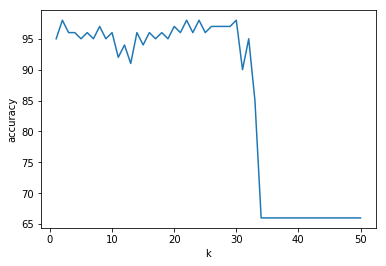

In [21]:
%pylab inline

def knn(x,data,k,n_classes,p=2): 
    votes = np.zeros(n_classes)
    
    distances = minkowski_mat(x,data[:,:-1])
    # take the k closest neighbour indices
    ind_neighbours = np.argsort(distances)[:k]
    cl_neighbours = data[ind_neighbours,-1].astype(int) - 1  # -1 car les cibles sont de 1 à 3 et on veut accèder aux index 0 à 2 de les_comptes
    for j in range(min(k,data.shape[0])): # on prend le min de k et data.shape[0] pour permettre un k plus grand que le nombre d'exemples (même si ça n'a pas de sens)
        votes[cl_neighbours[j]] += 1
    return np.argmax(votes)

# test kNN from k=1 to K
K = 50
n_classes = 3
ks = range(1,K+1)
results = np.zeros(len(ks))
for i, k in enumerate(ks):
    test_predictions = np.zeros(test_set.shape[0])
    for j in range(test_set.shape[0]):
        test_predictions[j] = knn(test_set[j,:-1],train_set,k,n_classes)
        
    results[i] = (1.0-(test_predictions==test_set[:,-1]).mean())*100.0
    
print("Best result with k =",ks[np.argmax(results)])
print("Best test accuracy ", np.max(results))

# graphique du % d'erreur en fonction de k
x = np.linspace(1, K,K)
plt.xlabel("k")
plt.ylabel("accuracy")
line, = plt.plot(x, results)

* explain what happens if you set $k=100$

If you have 100 training examples and you set $k = 100$ you are taking all the training examples as neighbours regardless of the distance. In that case, all training examples are voting and each test example, regardless of features will be labelled with the mode of the training examples targets (e.g. every test example is labelled class 1)